# Tutorial 3.1: Getting started with GANs

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Under_Construction&color=orange)


**Open notebook on:** 
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/clandolt/mlcysec_notebooks/blob/main/source/tutorial_notebooks/tutorial2_anomaly_detection/tutorial2_anomaly_detection.ipynb)   
**Author:** Christoph R. Landolt


In tutorial 2.2, we explored the Variational Autoencoder (VAE), a type of generative model. Another, fundamentally different architecture used for data generation is the Generative Adversarial Network (GAN), which consists of two competing neural networks, each with its own objective.

A **Generator** network creates new samples, aiming to produce data indistinguishable from real data. A **Discriminator** network aims to correctly classify samples as either real or synthetically generated by the Generator. This setup creates a competitive, adversarial dynamic.

This adversarial training setup has **dual-use applications** in cybersecurity: it can be used to train highly sophisticated detector networks for Intrusion Detection Systems (IDS), or, conversely, to train 'smart' generators capable of creating evasive attack samples that bypass machine learning-driven IDSs. In this tutorial, we will learn how to implement and train a simple GAN in PyTorch.

## Tutorial Objectives
By the end of this tutorial, you will be able to:
- Explain the core architecture and **adversarial objective** of a Generative Adversarial Network (GAN).
- Implement the Generator and Discriminator neural networks in PyTorch.

## Game Theory and Generative Adversarial Networks (GANs)

Generative Adversarial Networks (GANs) represent a game between two neural networks trained in an adversarial manner to reach a **zero-sum Nash equilibrium profile**. In this setup, the Generator and Discriminator are engaged in a competitive **minimax game**, striving to outmaneuver each other.

### Basics of GANs in Terms of Game Theory

GANs can be understood as a zero-sum, two-player minimax game, where the two players are the **Generator** $G(z)$ and the **Discriminator** $D(x)$.

<img src="./vanilla_GAN_Architecture.jpg" alt="vanilla_GAN_Architecture" width="600"/>


#### Players

- **Generator $G(z; \theta_G)$:**
    The generator takes a random noise vector $z$, sampled from a prior noise distribution $p_z(z)$ (usually uniform or Gaussian), and maps it to approximate the training data distribution $p_g(x)$. The goal of $G$ is to generate samples indistinguishable from the real data distribution $p_{\text{data}}(x)$.

- **Discriminator $D(x; \theta_D)$:**
    The discriminator takes an input $x$ (either a real sample from $p_{\text{data}}(x)$ or a fake sample from the generator $G$) and outputs a probability $D(x)$ in the range $[0, 1]$, representing its confidence that $x$ is a real sample.

#### Objective

The GAN framework’s objective is to find the Nash equilibrium of the following **minimax game**:

$$
\min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

Different choices for the functions $\log D(x)$ and $\log(1 - D(G(z)))$ lead to variations in GAN objectives and metrics (e.g., WGAN, LSGAN).
<table class="tutorial-table" border="1" style="width:100%; border-collapse: collapse;">
    <thead>
        <tr>
            <th>Variant</th>
            <th>f0(D)</th>
            <th>f1(D)</th>
            <th>Divergence Metric</th>
            <th>Game Value</th>
            <th>Description</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><b>Vanilla GAN</b></td>
            <td>log D</td>
            <td>log(1 - D)</td>
            <td>Jensen-Shannon Divergence (JSD)</td>
            <td>- log 4</td>
            <td>The original GAN formulation by Goodfellow et al. (2014).</td>
        </tr>
        <tr>
            <td><b>Wasserstein GAN (WGAN)</b></td>
            <td>D</td>
            <td>-D</td>
            <td>Wasserstein-1 Distance (Earth Mover's)</td>
            <td>0</td>
            <td>WGAN uses the Earth Mover's distance (Wasserstein-1) as a metric, providing better gradients.</td>
        </tr>
        <tr>
            <td><b>Hinge GAN</b></td>
            <td>min(0, -1 + D)</td>
            <td>min(0, -1 - D)</td>
            <td>Hinge Loss</td>
            <td>0</td>
            <td>Hinge loss encourages the discriminator to correctly classify real and fake samples with a margin.</td>
        </tr>
        <tr>
            <td><b>f-GAN (KL)</b></td>
            <td>log D</td>
            <td>1 - D</td>
            <td>Kullback-Leibler (KL) Divergence</td>
            <td>0</td>
            <td>f-GAN with KL divergence as the f-divergence.</td>
        </tr>
        <tr>
            <td><b>f-GAN (Reverse KL)</b></td>
            <td>-D</td>
            <td>log D</td>
            <td>Reverse Kullback-Leibler (Reverse KL)</td>
            <td>-1</td>
            <td>f-GAN with Reverse KL divergence as the f-divergence.</td>
        </tr>
    </tbody>
</table>

The original formulation by [Goodfellow et al.](https://arxiv.org/abs/1406.2661) uses **cross-entropy loss** for adversarial dynamics.

*   [**Wasserstein GAN (WGAN):**](https://arxiv.org/abs/1701.07875) Uses the **Earth Mover’s distance** for stable gradient flow and improved convergence.
*   **Hinge GAN:** Uses the **Hinge Loss** and encourages a margin between correct and incorrect classifications.

### Detailed Objectives

#### Discriminator’s Objective

The discriminator $D$ seeks to **maximize** its ability to distinguish real samples ($x$) from fake samples ($G(z)$):

$$
\max_D V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

#### Generator’s Objective

The generator $G$ seeks to **minimize** the discriminator’s ability to correctly classify fake samples as generated:

$$
\min_G V(D, G) = \mathbb{E}_{z \sim p_z(z)}[\log(1 - D(G(z)))]
$$

### Minimax Game Interpretation

The GAN framework models a **zero-sum game** where the generator $G$ and the discriminator $D$ compete.

*   The generator $G$ aims to create samples that are indistinguishable from real data.
*   The discriminator $D$ aims to accurately classify samples as real or generated.

The **Nash equilibrium** is reached when $p_g = p_{\text{data}}$ and the discriminator is unable to distinguish the two distributions, resulting in:

$$
D^*(x)=0.5 \quad \text{for all } x
$$

#### Optimality

The optimal discriminator $D^*$ and generator $G^*$ satisfy:

$$
D^*(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_g(x)}
$$

and

$$
p_g = p_{\text{data}}
$$

At this point, the generator perfectly replicates the real data distribution, and the discriminator cannot distinguish between real and generated samples. This game-theoretic foundation not only explains the dynamics of GANs but also highlights their flexibility for various tasks, from image synthesis to adversarial data generation.

The training loss highlights the challenges of training GANs. Unlike standard neural networks, where a single optimum is sought, GANs require learning an equilibrium between the generator and discriminator, which can result in instabilities and oscillatory behavior. As a result, stabilizing GAN training is crucial for effective learning.


Epoch [0/10000], Loss D: 1.8986107110977173, Loss G: 0.8265607357025146
Epoch [100/10000], Loss D: 1.091135025024414, Loss G: 0.7278845310211182
Epoch [200/10000], Loss D: 1.085075855255127, Loss G: 0.9277796745300293
Epoch [300/10000], Loss D: 1.1726617813110352, Loss G: 0.9456811547279358
Epoch [400/10000], Loss D: 1.1486120223999023, Loss G: 1.0579707622528076
Epoch [500/10000], Loss D: 0.4085472822189331, Loss G: 1.896259069442749
Epoch [600/10000], Loss D: 1.1373995542526245, Loss G: 0.9162259101867676
Epoch [700/10000], Loss D: 1.357154369354248, Loss G: 0.782399594783783
Epoch [800/10000], Loss D: 1.10955011844635, Loss G: 0.9920153021812439
Epoch [900/10000], Loss D: 1.468536376953125, Loss G: 0.9449710845947266
Epoch [1000/10000], Loss D: 1.538872480392456, Loss G: 0.8086546659469604
Epoch [1100/10000], Loss D: 1.6196037530899048, Loss G: 0.7537198066711426
Epoch [1200/10000], Loss D: 1.4985761642456055, Loss G: 0.7154883146286011
Epoch [1300/10000], Loss D: 1.581352949142456,

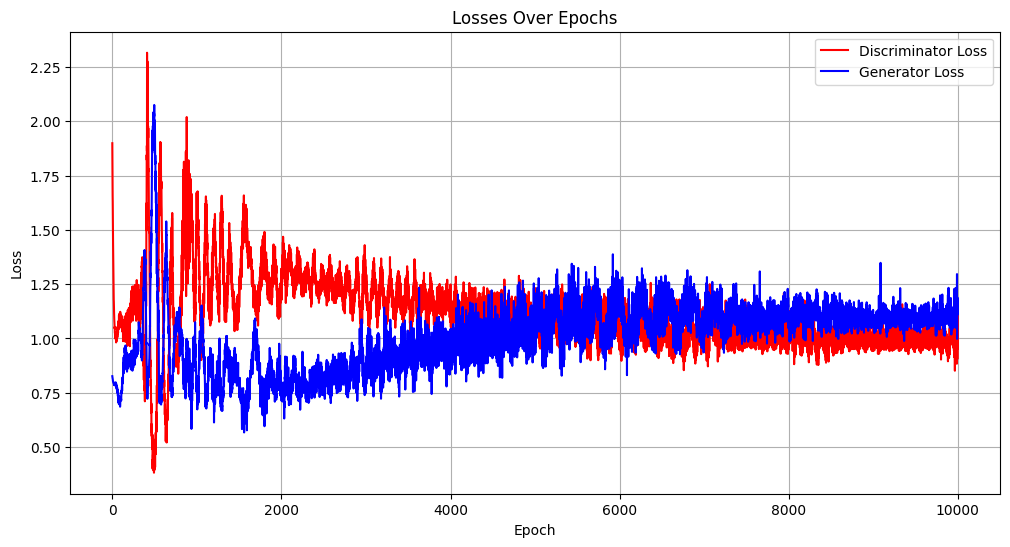

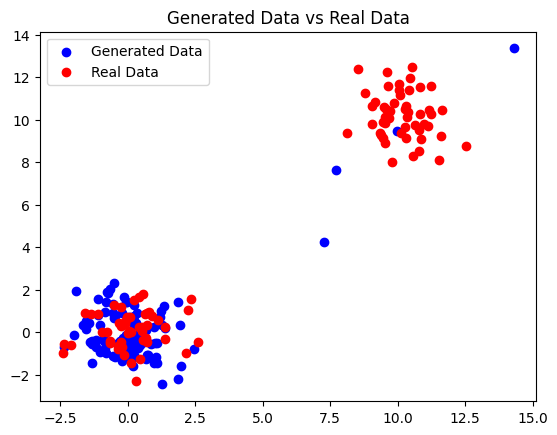

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(10, 50),  # Input dimension is 10 (noise), output dimension is 50
            nn.ReLU(),
            nn.Linear(50, 2)    # Output dimension is 2 (for 2D data)
        )
        
    def forward(self, x):
        return self.fc(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 50),   # Input dimension is 2 (for 2D data), output dimension is 50
            nn.ReLU(),
            nn.Linear(50, 1),   # Output dimension is 1 (for binary classification)
            nn.Sigmoid()        # Sigmoid activation to output probabilities
        )
        
    def forward(self, x):
        return self.fc(x)

# Initialize models, loss function, and optimizers
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)

# Toy dataset with Gaussian distribution
def generate_real_data(batch_size=64, mean1=0.0, mean2=10.0, std=1.0):
    # Half of the samples from mean1
    half_batch = batch_size // 2
    data1 = np.random.normal(mean1, std, (half_batch, 2))
    
    # Half of the samples from mean2
    data2 = np.random.normal(mean2, std, (batch_size - half_batch, 2))
    
    # Combine both parts
    combined_data = np.vstack([data1, data2])
    
    # Convert to torch tensor
    return torch.tensor(combined_data, dtype=torch.float32)


def generate_noise(batch_size=64, noise_dim=10):
    return torch.tensor(np.random.randn(batch_size, noise_dim), dtype=torch.float32)

# Training parameters
num_epochs = 10000
batch_size = 64
noise_dim = 10

losses_d = []
losses_g = []

# Training loop
for epoch in range(num_epochs):
    # Train Discriminator
    optimizer_d.zero_grad()
    
    # Generate real and fake data
    real_data = generate_real_data(batch_size)
    fake_data = generator(generate_noise(batch_size, noise_dim)).detach()  # Detach to avoid updating generator
    
    # Discriminator on real data
    real_labels = torch.ones(batch_size, 1)
    output_real = discriminator(real_data)
    loss_d_real = criterion(output_real, real_labels)
    
    # Discriminator on fake data
    fake_labels = torch.zeros(batch_size, 1)
    output_fake = discriminator(fake_data)
    loss_d_fake = criterion(output_fake, fake_labels)
    
    # Total loss and update Discriminator
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    optimizer_d.step()
    
    # Train Generator
    optimizer_g.zero_grad()
    
    # Generate new fake data
    fake_data = generator(generate_noise(batch_size, noise_dim))
    
    # Try to fool the discriminator
    real_labels = torch.ones(batch_size, 1)  # We want discriminator to think these are real
    output_fake = discriminator(fake_data)
    loss_g = criterion(output_fake, real_labels)
    
    # Update Generator
    loss_g.backward()
    optimizer_g.step()

    # Save losses
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())
    
    # Print progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G: {loss_g.item()}')

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(losses_d, label='Discriminator Loss', color='red')
plt.plot(losses_g, label='Generator Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot results
with torch.no_grad():
    noise = generate_noise(100, noise_dim)
    generated_data = generator(noise).numpy()

plt.scatter(generated_data[:, 0], generated_data[:, 1], c='blue', label='Generated Data')
plt.scatter(generate_real_data(100).numpy()[:, 0], generate_real_data(100).numpy()[:, 1], c='red', label='Real Data')
plt.legend()
plt.title('Generated Data vs Real Data')
plt.show()


### 2.2.1. Game-Theoretic Approaches to GANs

Game theory provides a natural framework for analyzing and improving the training and performance of GANs. Since GANs inherently involve a two-player zero-sum game between the generator and the discriminator, applying advanced game-theoretic models has shown promise in overcoming several of GANs’ fundamental challenges, such as instability, non-convergence, and mode collapse. Below are notable advancements categorized by their game-theoretic approaches:

*   **Stochastic Games:** Traditional GAN training often struggles with convergence due to the non-convex nature of the loss landscape. One approach casts the GAN training process as a **Stochastic Nash Equilibrium Problem (SNEP)**, which is reformulated into a **Stochastic Variational Inequality (SVI)**. Algorithms like the Stochastic Relaxed Forward-Backward (SRFB) have been proposed to address convergence by relying on monotonicity in the pseudogradient mapping. These methods allow for the use of smaller mini-batch samples without compromising convergence, making training more feasible.

*   **Stackelberg Games:** Unlike the simultaneous play in traditional GANs, **Stackelberg GANs** introduce a **leader-follower dynamic**, where the generator acts as a leader and the discriminator as a follower. This sequential setup aligns better with the natural order of GAN training and enhances stability. Techniques like proximal training further ensure convergence by regularizing the discriminator’s optimization process, transitioning between Stackelberg and Nash equilibria based on specific hyperparameters.

*   **Bi-Affine Games:** This approach reformulates GAN training from a **mixed Nash Equilibria** perspective, enabling better handling of the lack of convexity in GAN objectives. By incorporating mixed strategies, bi-affine games expand the solution space, allowing GANs to achieve global optima in infinite-dimensional settings, thereby improving overall performance.

*   **Architectural Modifications:** Game theory also informs architectural changes to GANs. For instance, **Multi-Agent Diverse GANs (MAD-GANs)** leverage game-theoretic principles to employ multiple generators and discriminators, addressing issues like **mode collapse** by ensuring diverse output generation. These architectures often integrate concepts like Nash or Stackelberg equilibria for enhanced training dynamics.

These game-theoretic advancements illustrate the potential of adapting theoretical models to tackle practical challenges in GAN training, opening pathways for more robust and efficient generative models.
<img src="./multi_stackelber_GAN_Architecture.jpg" alt="multi_stackelber_GAN_Architecture" width="600"/>
These advancements showcase the evolution of adversarial models and their adaptability in solving complex problems.



Epoch [0/10000], Loss D: 1.71209716796875, Loss G Leader: 0.7377135157585144, Loss G Follower: 0.7309105396270752
Epoch [100/10000], Loss D: 1.3177158832550049, Loss G Leader: 1.2935774326324463, Loss G Follower: 1.2343732118606567
Epoch [200/10000], Loss D: 1.2597970962524414, Loss G Leader: 1.2015361785888672, Loss G Follower: 2.4777989387512207
Epoch [300/10000], Loss D: 1.4006596803665161, Loss G Leader: 1.5859103202819824, Loss G Follower: 2.051293134689331
Epoch [400/10000], Loss D: 2.1924543380737305, Loss G Leader: 1.326869010925293, Loss G Follower: 1.3878788948059082
Epoch [500/10000], Loss D: 2.0666542053222656, Loss G Leader: 1.1534104347229004, Loss G Follower: 1.3446600437164307
Epoch [600/10000], Loss D: 2.2531964778900146, Loss G Leader: 1.1677346229553223, Loss G Follower: 0.8939422369003296
Epoch [700/10000], Loss D: 1.9100061655044556, Loss G Leader: 1.3258246183395386, Loss G Follower: 0.9488023519515991
Epoch [800/10000], Loss D: 1.8935530185699463, Loss G Leader: 

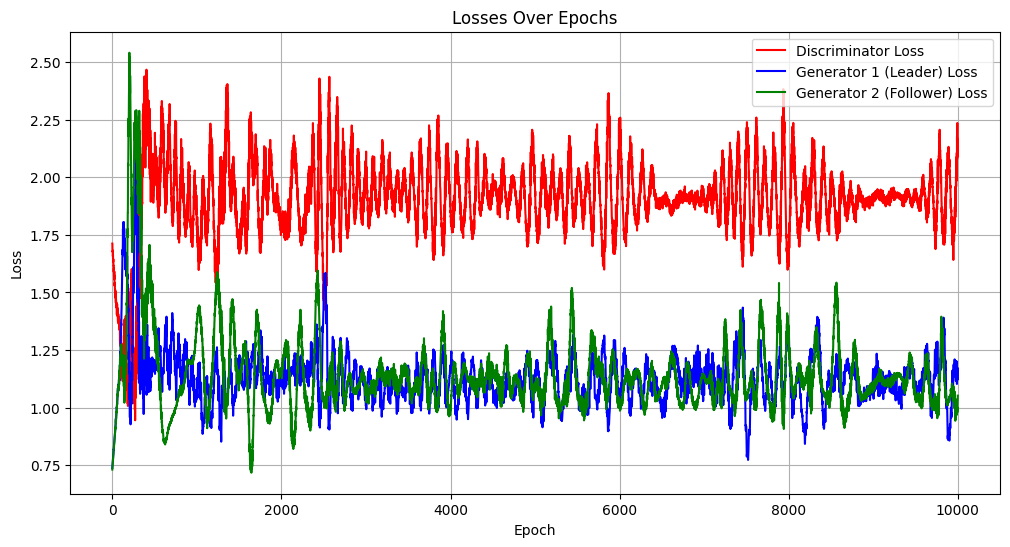

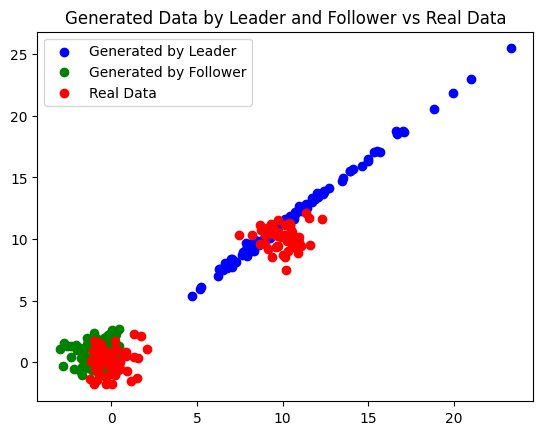

In [3]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Define the Generator models
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, output_dim)
        )
        
    def forward(self, x):
        return self.fc(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.fc(x)

# Initialize models, loss function, and optimizers
input_dim = 10  # Dimension of noise vector
output_dim = 2  # Dimension of generated data (2D)
generator_leader = Generator(input_dim, output_dim)
generator_follower = Generator(input_dim, output_dim)
discriminator = Discriminator(output_dim)
criterion = nn.BCELoss()
optimizer_g_leader = optim.Adam(generator_leader.parameters(), lr=0.001)
optimizer_g_follower = optim.Adam(generator_follower.parameters(), lr=0.001)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.001)



# Toy dataset with Gaussian distribution
def generate_real_data(batch_size=64, mean1=0.0, mean2=10.0, std=1.0):
    # Half of the samples from mean1
    half_batch = batch_size // 2
    data1 = np.random.normal(mean1, std, (half_batch, 2))
    
    # Half of the samples from mean2
    data2 = np.random.normal(mean2, std, (batch_size - half_batch, 2))
    
    # Combine both parts
    combined_data = np.vstack([data1, data2])
    
    # Convert to torch tensor
    return torch.tensor(combined_data, dtype=torch.float32)


def generate_noise(batch_size=64):
    return torch.tensor(np.random.randn(batch_size, input_dim), dtype=torch.float32)

# Training parameters
num_epochs = 10000
batch_size = 64

losses_d = []
losses_g_leader = []
losses_g_follower = []

# Training loop
for epoch in range(num_epochs):
    # Train Discriminator
    optimizer_d.zero_grad()
    
    # Generate data from both generators
    noise = generate_noise(batch_size)
    fake_data_leader = generator_leader(noise)
    fake_data_follower = generator_follower(noise).detach()  # Detach to avoid updating follower during leader training
    
    # Discriminator on real data
    real_data = generate_real_data(batch_size)
    real_labels = torch.ones(batch_size, 1)
    output_real = discriminator(real_data)
    loss_d_real = criterion(output_real, real_labels)
    
    # Discriminator on fake data
    fake_labels = torch.zeros(batch_size, 1)
    output_fake_leader = discriminator(fake_data_leader)
    output_fake_follower = discriminator(fake_data_follower)
    loss_d_fake = criterion(output_fake_leader, fake_labels) + criterion(output_fake_follower, fake_labels)
    
    # Total loss and update Discriminator
    loss_d = loss_d_real + loss_d_fake
    loss_d.backward()
    optimizer_d.step()
    
    # Train Generator Leader
    optimizer_g_leader.zero_grad()
    
    # Generate new fake data from the leader
    fake_data_leader = generator_leader(generate_noise(batch_size))
    
    # The leader's goal is to fool the discriminator
    real_labels = torch.ones(batch_size, 1)  # We want the discriminator to think these are real
    output_fake_leader = discriminator(fake_data_leader)
    loss_g_leader = criterion(output_fake_leader, real_labels)
    
    # Update Leader Generator
    loss_g_leader.backward()
    optimizer_g_leader.step()
    
    # Train Generator Follower
    optimizer_g_follower.zero_grad()
    
    # Generate new fake data from the follower
    fake_data_follower = generator_follower(generate_noise(batch_size))
    
    # The follower's goal is to fool the discriminator considering the leader's actions
    real_labels = torch.ones(batch_size, 1)  # We want the discriminator to think these are real
    output_fake_follower = discriminator(fake_data_follower)
    loss_g_follower = criterion(output_fake_follower, real_labels)
    
    # Update Follower Generator
    loss_g_follower.backward()
    optimizer_g_follower.step()

    losses_d.append(loss_d.item())
    losses_g_leader.append(loss_g_leader.item())
    losses_g_follower.append(loss_g_follower.item())
    
    # Print progress
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss D: {loss_d.item()}, Loss G Leader: {loss_g_leader.item()}, Loss G Follower: {loss_g_follower.item()}')

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(losses_d, label='Discriminator Loss', color='red')
plt.plot(losses_g_leader, label='Generator 1 (Leader) Loss', color='blue')
plt.plot(losses_g_follower, label='Generator 2 (Follower) Loss', color='green')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot results
with torch.no_grad():
    noise = generate_noise(100)
    generated_data_leader = generator_leader(noise).numpy()
    generated_data_follower = generator_follower(noise).numpy()

plt.scatter(generated_data_leader[:, 0], generated_data_leader[:, 1], c='blue', label='Generated by Leader')
plt.scatter(generated_data_follower[:, 0], generated_data_follower[:, 1], c='green', label='Generated by Follower')
plt.scatter(generate_real_data(100).numpy()[:, 0], generate_real_data(100).numpy()[:, 1], c='red', label='Real Data')
plt.legend()
plt.title('Generated Data by Leader and Follower vs Real Data')
plt.show()

## Conclusion


---

[![Star our repository](https://img.shields.io/static/v1.svg?logo=star&label=⭐&message=Star%20Our%20Repository&color=yellow)](https://github.com/clandolt/mlcysec_notebooks/)  If you found this tutorial helpful, please **⭐ star our repository** to show your support.   
[![Ask questions](https://img.shields.io/static/v1.svg?logo=star&label=❔&message=Ask%20Questions&color=9cf)](https://github.com/clandolt/mlcysec_notebooks/issues)  For any **questions**, **typos**, or **bugs**, kindly open an issue on GitHub — we appreciate your feedback!

---